# Run

## Imports

In [1]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.2 MB/s eta 0:00:00


In [2]:
# Ставим зависимости
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0/
!./configure --prefix=/usr
!make
!make install
%cd ..
# Устанавливаем python-обертку
!pip install Ta-Lib
import talib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-09-28 14:00:33--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-09-28 14:00:33--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import talib
import random
import datetime
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Funcrions

In [7]:
def generate_months(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m')
    end_date = datetime.strptime(end_date, '%Y-%m')
    months = []

    while start_date <= end_date:
        months.append(start_date.strftime('%Y-%m'))
        start_date = start_date + relativedelta(months=1)

    return months


# Загрузка данных с Binance
def download_klines(symbol, interval, start_date, end_date):
    months = generate_months(start_date, end_date)
    if not os.path.exists('klines'):
        os.mkdir('klines')

    klines = {
        'Date': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': []
    }

    for month in months:
        filename = f"{symbol}-{interval}-{month}.zip"
        file_path = f"klines/{filename}"

        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            url = f"https://data.binance.vision/data/futures/um/monthly/klines/{symbol}/{interval}/{filename}"
            try:
                r = requests.get(url, allow_redirects=True)
                with open(file_path, 'wb') as f:
                    f.write(r.content)
            except Exception as e:
                print(f"Ошибка загрузки файла {filename}: {e}. Пропускаем.")
                continue

        try:
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                with zip_file.open(f"{symbol}-{interval}-{month}.csv", 'r') as csv_file:
                    csv_reader = csv.reader(io.TextIOWrapper(csv_file, 'utf-8'))
                    for row in csv_reader:
                        if row[0].isdigit():
                            klines['Date'].append(datetime.fromtimestamp(int(row[0]) / 1000, tz=timezone.utc))
                            klines['Open'].append(float(row[1]))
                            klines['High'].append(float(row[2]))
                            klines['Low'].append(float(row[3]))
                            klines['Close'].append(float(row[4]))
                            klines['Volume'].append(float(row[5]))
        except (zipfile.BadZipFile, KeyError):
            print(f"Ошибка: Файл {file_path} поврежден или не является ZIP. Пропускаем.")
            continue

    if not klines['Date']:
        raise ValueError(f"Нет доступных данных для {symbol} в диапазоне {start_date} - {end_date}")

    df = pd.DataFrame(klines)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

## Data extraction

In [12]:
# Data extraction
symbol = 'SOLUSDT'
interval = '1h'
start_date = '2022-09'
end_date = '2025-08'

data = download_klines(symbol, interval, start_date, end_date)

In [13]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2022-09-01 00:00:00+00:00,31.47,31.75,31.10,31.46,1301111.00
2022-09-01 01:00:00+00:00,31.45,31.63,31.32,31.49,653360.00
2022-09-01 02:00:00+00:00,31.49,31.64,31.31,31.39,464516.00
2022-09-01 03:00:00+00:00,31.39,31.50,30.94,31.20,777497.00
2022-09-01 04:00:00+00:00,31.20,31.40,31.08,31.33,426292.00
...,...,...,...,...,...
2025-08-31 19:00:00+00:00,205.55,205.97,204.33,204.53,611295.00
2025-08-31 20:00:00+00:00,204.53,205.13,204.22,204.75,298836.67
2025-08-31 21:00:00+00:00,204.75,205.35,204.18,205.29,252417.24


In [17]:
data.columns = data.columns.str.lower()
data.head()

,open,high,low,close,volume
Date,,,,,
2022-09-01 00:00:00+00:00,31.47,31.75,31.10,31.46,1301111.0
2022-09-01 01:00:00+00:00,31.45,31.63,31.32,31.49,653360.0
2022-09-01 02:00:00+00:00,31.49,31.64,31.31,31.39,464516.0
2022-09-01 03:00:00+00:00,31.39,31.50,30.94,31.20,777497.0
2022-09-01 04:00:00+00:00,31.20,31.40,31.08,31.33,426292.0


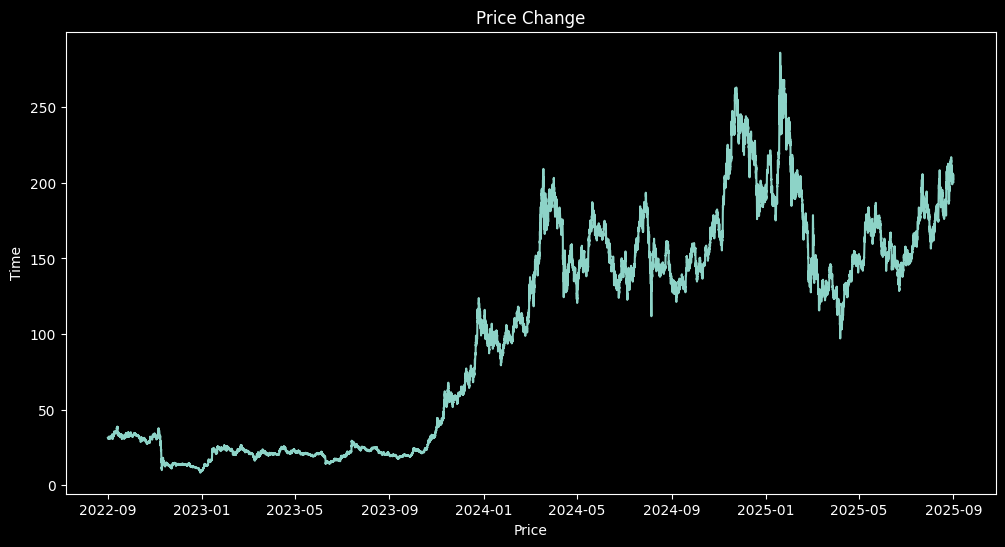

In [18]:
plt.style.use('dark_background')
flg, ax = plt.subplots(figsize=(12,6))
plt.plot(data.index, data['close'])
plt.xlabel('Price')
plt.ylabel('Time')
plt.title('Price Change')
plt.show()

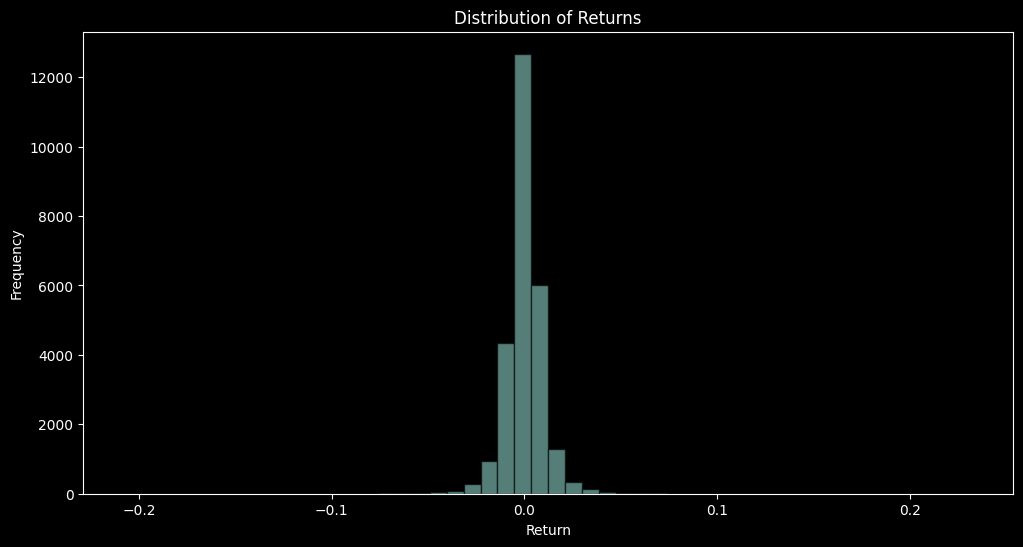

In [19]:
# simple yield calculation
data['return'] = data['close'].pct_change().shift(-1)

fig, ax = plt.subplots(figsize=(12,6))
plt.hist(data['return'], bins=50, edgecolor='black', alpha=0.6)
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.show()

Based on the graph, we can judge that the profitability has a normal distribution.

## Percentage price change algorithm

If the price per hour increases by half a percent, then put the mark 1, otherwise mark 0

In [20]:
precentage_chage = 0.005 # 0.5%

# set the mark
data['price_change'] = data['close'].pct_change() # percentage price change
data['binary_target'] = np.where(data['price_change'].shift(-1) > precentage_chage, 1, 0)

In [21]:
# check and remove duplicates in index
data = data[~data.index.duplicated(keep='first')]

In [22]:
# indecators culculations
data['SMA_10'] = talib.SMA(data['close'], timeperiod=10)
data['EMA_10'] = talib.EMA(data['close'], timeperiod=10)
data['RSI_14'] = talib.RSI(data['close'], timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['bollinger_high'], data['bollinger_mid'], data['bollinger_low'] = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

In [23]:
# functions for calculating patterns
import pandas as pd

def is_doji(row, threshold=0.1):
    return abs(row['open'] - row['close']) <= threshold

def is_hammer(row):
    body = abs(row['open'] - row['close'])
    lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
    upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
    return lower_shadow > 2 * body and upper_shadow < body

def is_bullish_engulfing(current_row, previous_row):
    return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
           current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

def is_piercing_line(current_row, previous_row):
    return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
            current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

def is_morning_star(current_row, previous_row, pre_previous_row):
    return pre_previous_row['close'] < pre_previous_row['open'] and \
          abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
          current_row['close'] > current_row['open'] and \
          current_row['open'] < previous_row['close'] and \
          current_row['close'] > (previous_row['close'] + previous_row['open']) / 2

def is_inverted_hammer(row):
    body = abs(row['open'] - row['close'])
    upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
    lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
    return upper_shadow > 2 * body and lower_shadow < body

def is_three_white_soldiers(df, idx):
    if idx < 2:
        return False
    current = df.iloc[idx]
    prev1 = df.iloc[idx - 1]
    prev2 = df.iloc[idx - 2]
    return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
           all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
           all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

def is_harami_cross(current_row, previous_row):
    return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
           previous_row['open'] > previous_row['close'] and current_row['high'] < previous_row['open' ] and current_row['low'] > previous_row['close']

data['doji'] = data.apply(is_doji, axis=1)
data['hammer'] = data.apply(is_hammer, axis=1)
data['bull_engulfing'] = data.apply(lambda row: is_bullish_engulfing(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
data['piercing_line'] = data.apply(lambda row: is_piercing_line(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
data['morning_star'] = data.apply(lambda row: is_morning_star(row, data.iloc[data.index.get_loc(row.name) - 1], data.iloc[data.index.get_loc(row.name) - 2]) if data.index.get_loc(row.name) > 1 else False, axis=1)
data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
data['three_white_soldiers'] = data.apply(lambda row: is_three_white_soldiers(data, data.index.get_loc(row.name)), axis=1)
data['harami_cross'] = data.apply(lambda row: is_harami_cross(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2022-09-01 00:00:00+00:00 to 2025-08-31 23:00:00+00:00
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  26304 non-null  float64
 1   high                  26304 non-null  float64
 2   low                   26304 non-null  float64
 3   close                 26304 non-null  float64
 4   volume                26304 non-null  float64
 5   return                26303 non-null  float64
 6   price_change          26303 non-null  float64
 7   binary_target         26304 non-null  int64  
 8   SMA_10                26295 non-null  float64
 9   EMA_10                26295 non-null  float64
 10  RSI_14                26290 non-null  float64
 11  MACD                  26271 non-null  float64
 12  MACD_signal           26271 non-null  float64
 13  bollinger_high        26285 non-null  float64
 14  bollinger_mid         2

In [25]:
data.head(3)

,open,high,low,close,volume,return,price_change,binary_target,SMA_10,EMA_10,...,bollinger_mid,bollinger_low,doji,hammer,bull_engulfing,piercing_line,morning_star,inverted_hammer,three_white_soldiers,harami_cross
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,31.47,31.75,31.10,31.46,1301111.0,0.000954,NaN,0,NaN,NaN,...,NaN,NaN,True,False,False,False,False,False,False,False
2022-09-01 01:00:00+00:00,31.45,31.63,31.32,31.49,653360.0,-0.003176,0.000954,0,NaN,NaN,...,NaN,NaN,True,False,True,False,False,False,False,False
2022-09-01 02:00:00+00:00,31.49,31.64,31.31,31.39,464516.0,-0.006053,-0.003176,0,NaN,NaN,...,NaN,NaN,True,False,False,False,False,False,False,False


In [26]:
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)

#data['historical_volatility'] = talib.NATR(data['high'], data['low'], data['close'], timeperiod=14)
data['historical_volatility'] = data['close'].pct_change().rolling(window=14).std() * np.sqrt(252)

data['volume_mean_10'] = data['volume'].rolling(window=10).mean()
data['volume_mean_30'] = data['volume'].rolling(window=30).mean()

data['parabolic_SAR'] = talib.SAR(data['high'], data['low'], acceleration=0.02, maximum=0.2)
data['ADX'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)

data['stochastic_oscillator_k'], data['stochastic_oscillator_d'] = talib.STOCH(data['high'], data['low'], data['close'],
                                                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                                                               slowd_period=3, slowd_matype=0)

data['CCI'] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=14)

data['SMA_50'] = talib.SMA(data['close'], timeperiod=50)
data['SMA_200'] = talib.SMA(data['close'], timeperiod=200)
data['EMA_50'] = talib.EMA(data['close'], timeperiod=50)
data['EMA_200'] = talib.EMA(data['close'], timeperiod=200)

# Removing rows with NaN values
data.dropna(inplace=True)
data.head()

,open,high,low,close,volume,return,price_change,binary_target,SMA_10,EMA_10,...,volume_mean_30,parabolic_SAR,ADX,stochastic_oscillator_k,stochastic_oscillator_d,CCI,SMA_50,SMA_200,EMA_50,EMA_200
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-09 07:00:00+00:00,35.29,35.40,35.02,35.36,968528.0,0.007353,0.001984,1,34.506,34.645889,...,1.006507e+06,33.859661,41.531417,90.159902,91.006177,114.237259,32.7908,31.8756,33.191172,31.875600
2022-09-09 08:00:00+00:00,35.37,35.96,35.30,35.62,1558427.0,-0.005334,0.007353,0,34.718,34.823000,...,1.047656e+06,34.064901,43.700084,90.317026,90.370050,122.623635,32.8820,31.8964,33.286420,31.912858
2022-09-09 09:00:00+00:00,35.62,35.66,35.18,35.43,1161014.0,0.007338,-0.005334,1,34.901,34.933364,...,1.076380e+06,34.330215,45.244510,87.069141,89.182023,88.597376,32.9692,31.9161,33.370482,31.947854
2022-09-09 10:00:00+00:00,35.43,35.78,35.30,35.69,950666.0,-0.009246,0.007338,0,35.054,35.070934,...,1.089730e+06,34.558385,46.776557,86.243076,87.876414,89.742733,33.0582,31.9376,33.461443,31.985089
2022-09-09 11:00:00+00:00,35.69,35.73,35.11,35.36,899930.0,-0.003394,-0.009246,0,35.184,35.123492,...,1.107148e+06,34.754611,47.447147,82.323232,85.211816,63.236135,33.1416,31.9584,33.535896,32.018671


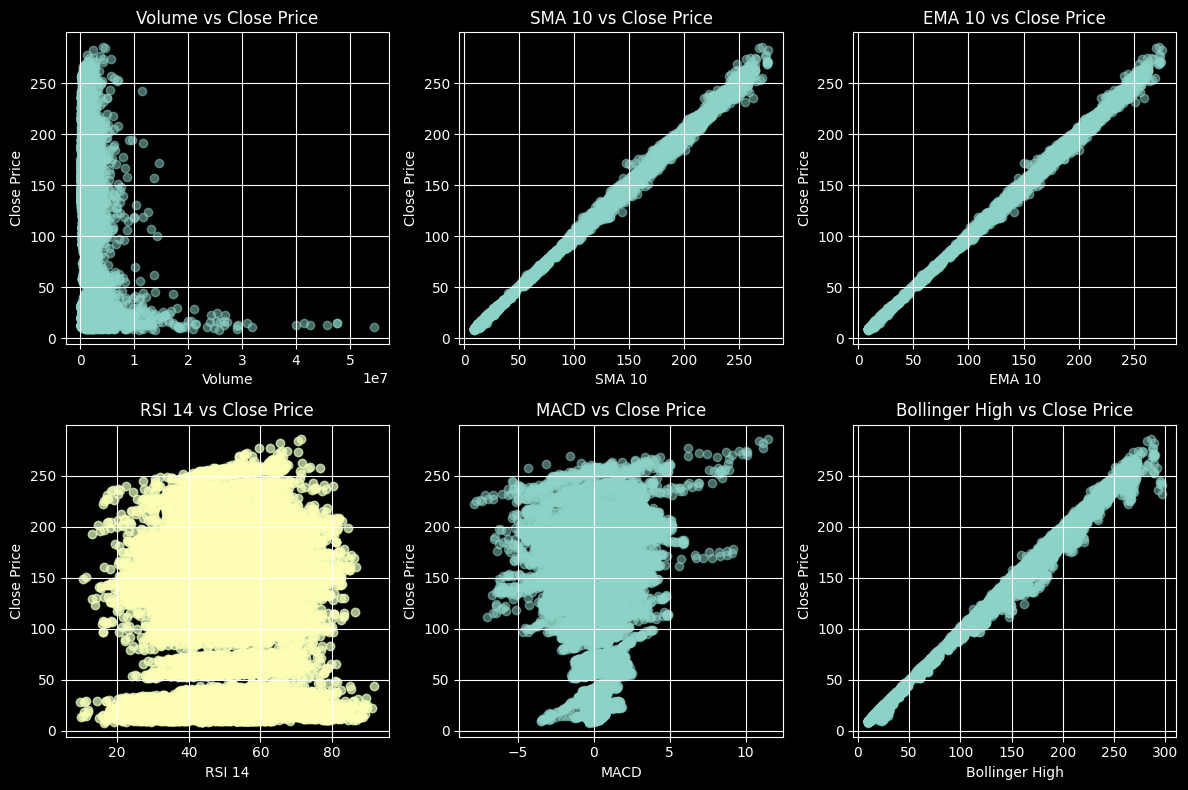

In [27]:
# Visualizing indicators
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))


# Scatter plot: Close price vs volume
axes[0, 0].scatter(data['volume'], data['close'], alpha=0.5)
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Close Price')
axes[0, 0].set_title('Volume vs Close Price')
axes[0, 0].grid(True)

# Scatter plot: Close price vs SMA 10
axes[0, 1].scatter(data['SMA_10'], data['close'], alpha=0.5)
axes[0, 1].set_xlabel('SMA 10')
axes[0, 1].set_ylabel('Close Price')
axes[0, 1].set_title('SMA 10 vs Close Price')
axes[0, 1].grid(True)

# Scatter plot: Close price vs EMA 10
axes[0, 2].scatter(data['EMA_10'], data['close'], alpha=0.5)
axes[0, 2].set_xlabel('EMA 10')
axes[0, 2].set_ylabel('Close Price')
axes[0, 2].set_title('EMA 10 vs Close Price')
axes[0, 2].grid(True)

# Scatter plot: Close price vs RSI 14
axes[1, 0].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('RSI 14')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('RSI 14 vs Close Price')
axes[1, 0].grid(True)

# Scatter plot: Close price vs RSI 14x
axes[1, 0].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('RSI 14')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('RSI 14 vs Close Price')
axes[1, 0].grid(True)

# Scatter plot: Close price vs MACD
axes[1, 1].scatter(data['MACD'], data['close'], alpha=0.5)
axes[1, 1].set_xlabel('MACD')
axes[1, 1].set_ylabel('Close Price')
axes[1, 1].set_title('MACD vs Close Price')
axes[1, 1].grid(True)

# Scatter plot: Close price vs Bollinger High bollinger_high
axes[1, 2].scatter(data['bollinger_high'], data['close'], alpha=0.5)
axes[1, 2].set_xlabel('Bollinger High')
axes[1, 2].set_ylabel('Close Price')
axes[1, 2].set_title('Bollinger High vs Close Price')
axes[1, 2].grid(True)


plt.tight_layout()
plt.show()

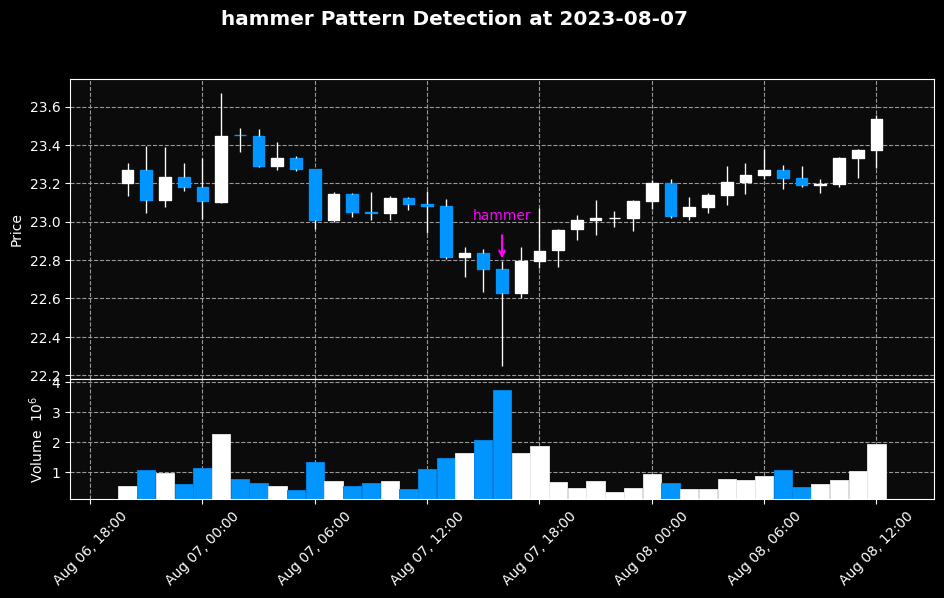

In [28]:
from ast import pattern
# Function for analyzing candlestick patterns

def plot_random_pattern(data, pattern_column, pattern_name):
    patterns = data[data[pattern_column] != 0]

    if patterns.empty:
      print(f"No occurences of {pattern_name} pattern found.")
      return

    random_index = random.choice(patterns.index)
    start_index = max(0, data.index.get_loc(random_index) - 20)
    end_index = min(len(data), data.index.get_loc(random_index) + 20)

    data_window = data.iloc[start_index:end_index+1]

    fig, axlist = mpf.plot(data_window, type='candle', style='nightclouds', volume=True,
                          title=f'{pattern_name} Pattern Detection at {random_index.date()}',
                          show_nontrading=True, returnfig=True, figsize=(12,6))

    axes = axlist[0]
    pattern_row = data.loc[random_index]

    # Add a short line to a candlestick plot
    axes.annotate('', xy=(random_index, pattern_row['high']),
                  xytext=(random_index, pattern_row['high'] + 0.15), # set the line size
                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5))

    axes.text(random_index, pattern_row['high'] + 0.2, pattern_name,
              horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='magenta')


# display a random pattern
plot_random_pattern(data, 'hammer', 'hammer')

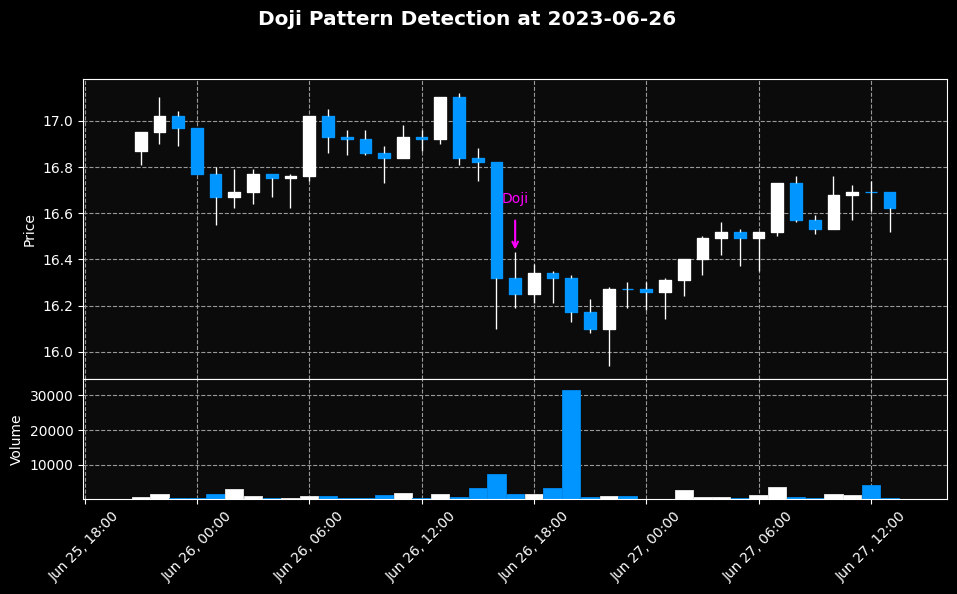

In [ ]:
plot_random_pattern(data, 'doji', 'Doji')

In [29]:
plot_random_pattern(data, 'harami_cross', 'harami_cross')

No occurences of harami_cross pattern found.


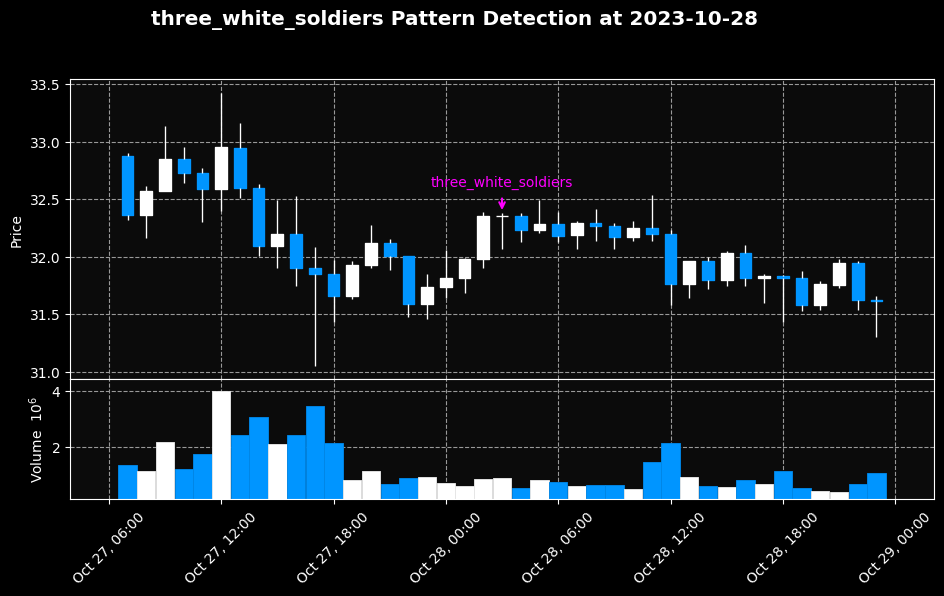

In [30]:
plot_random_pattern(data, 'three_white_soldiers', 'three_white_soldiers')

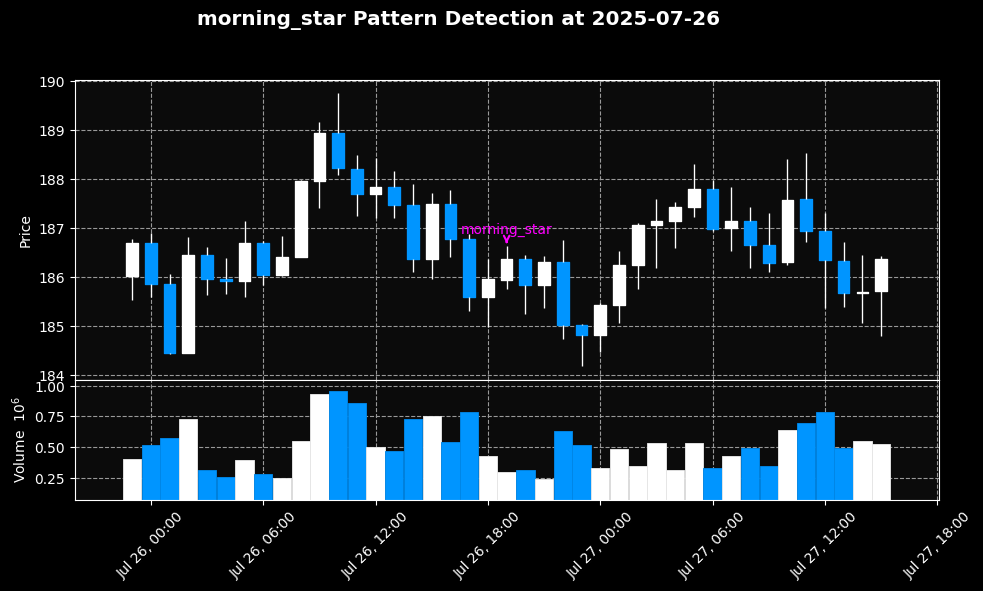

In [31]:
plot_random_pattern(data, 'morning_star', 'morning_star')

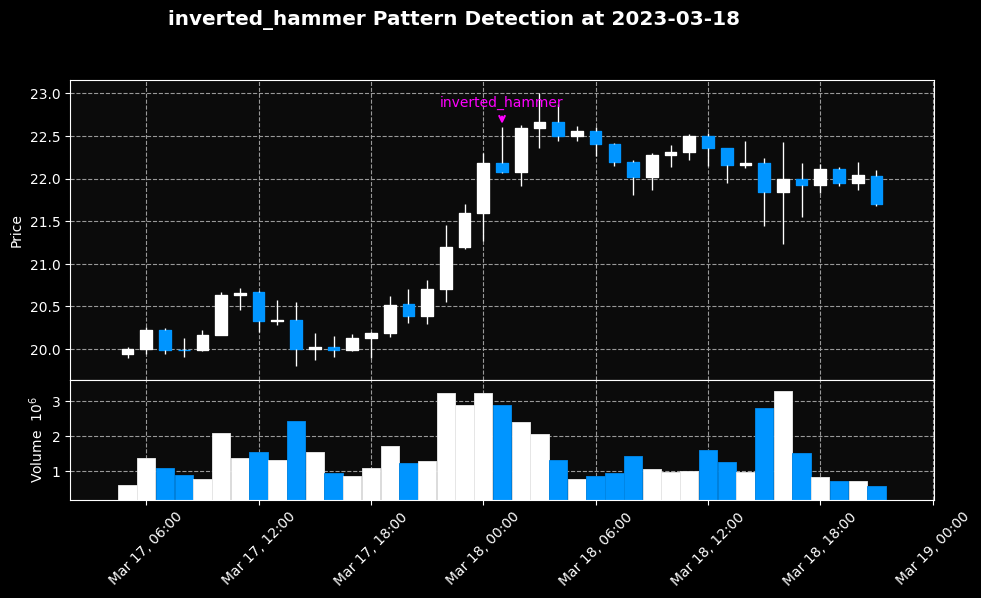

In [32]:
plot_random_pattern(data, 'inverted_hammer', 'inverted_hammer')

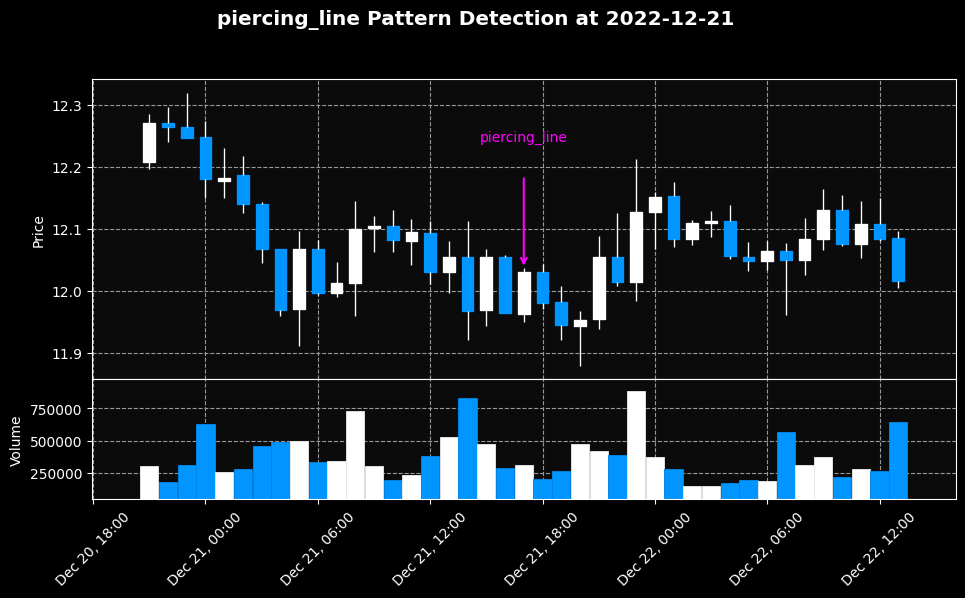

In [33]:
plot_random_pattern(data, 'piercing_line', 'piercing_line')

## Data splitting

In [34]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'price_change',
       'binary_target', 'SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal',
       'bollinger_high', 'bollinger_mid', 'bollinger_low', 'doji', 'hammer',
       'bull_engulfing', 'piercing_line', 'morning_star', 'inverted_hammer',
       'three_white_soldiers', 'harami_cross', 'ATR', 'historical_volatility',
       'volume_mean_10', 'volume_mean_30', 'parabolic_SAR', 'ADX',
       'stochastic_oscillator_k', 'stochastic_oscillator_d', 'CCI', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200'],
      dtype='object')

In [35]:
features = ['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal',
       'bollinger_high', 'bollinger_mid', 'bollinger_low', 'doji', 'hammer',
       'bull_engulfing', 'piercing_line', 'morning_star', 'inverted_hammer',
       'three_white_soldiers', 'harami_cross', 'ATR', 'historical_volatility',
       'volume_mean_10', 'volume_mean_30', 'parabolic_SAR', 'ADX',
       'stochastic_oscillator_k', 'stochastic_oscillator_d', 'CCI', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200']

X = data[features]
y = data['binary_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Train and evaluation

In [36]:

import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.740088 |
+-----------+----------+
| Precision | 0.358025 |
+-----------+----------+
| Recall    | 0.116747 |
+-----------+----------+
| F1        | 0.176078 |
+-----------+----------+
| ROC AUC   | 0.558378 |
+-----------+----------+


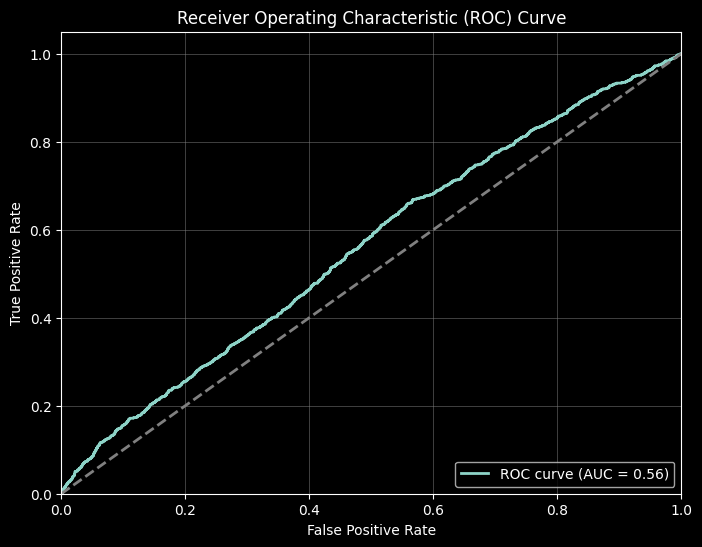


Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 3719 |                  260 |
+-----------------+----------------------+----------------------+
| Actual Positive |                 1097 |                  145 |
+-----------------+----------------------+----------------------+


In [38]:
metrics_table = [
    ['Accuracy', accuracy],
    ['Precision', precision],
    ['Recall', recall],
    ['F1', f1],
    ['ROC AUC', roc_auc]
]

print(tabulate(metrics_table, headers=['Metric', 'Value'], tablefmt='grid'))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_table = [['', 'Predicted Negative', 'Predicted Positive'],
                     ['Actual Negative', conf_matrix[0][0], conf_matrix[0][1]],
                     ['Actual Positive', conf_matrix[1][0], conf_matrix[1][1]]
                     ]

print('\nConfusion Matrix:')
print(tabulate(conf_matrix_table, headers='firstrow', tablefmt='grid'))

## Backtest

In [39]:
! pip install backtrader
import backtrader as bt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 10.7 MB/s eta 0:00:00


In [40]:
# Creating a Dataframe with test data and predictions

test_data = data.loc[X_test.index].copy()
test_data['predictions'] = y_pred

# Converting data to backtrader format
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predictions',)
    params = (
        ('predictions', -1),
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', None),
    )

In [41]:
class MLStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.01), # 1% stop loss
        ('take_profit', 0.1), # 10% take profit
        ('stake', 1000) # position size in dollars
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predictions = self.datas[0].predictions
        self.order = None # checking for existing order
        self.price = None
        self.stop_price = None
        self.take_profit_price = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return # orders sent / accepted by broker

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.stop_price = self.price * (1.0 - self.params.stop_loss)
                self.take_profit_price = self.price * (1.0 + self.params.take_profit)
            elif order.issell():
                self.log(f"SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def next(self):
        if self.order:
            return

        if not self.position:
            if self.predictions[0] > 0:
                self.order = self.buy(size=self.params.stake / self.dataclose[0])
                self.log(f'BUY CREATED, Price: {self.dataclose[0]:.2f}')

        else:
            if self.dataclose[0] <= self.stop_price or self.dataclose[0] >= self.take_profit_price:
                self.order = self.sell(size=self.position.size)
                self.log(f'SELL CREATED, Price: {self.dataclose[0]:.2f}')

        # Output current portfolio value for debugging
        self.log(f'Position Value: {self.broker.getvalue():.2f}')

In [42]:
# Create Cerebro and add data and strategy
cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)


# Convert data to backtrader format
datafeed = CustomPandasData(dataname=test_data)
cerebro.adddata(datafeed)

# Add Observer to track profile cost
cerebro.addobserver(bt.observers.Value)

# Initial funds
cerebro.broker.set_cash(10000.0)

# Set Commision
cerebro.broker.setcommission(commission=0.001)


# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strategies = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Getting profile values ​​and dates from Observer
portfolio_values = [ob for ob in strategies[0].observers if isinstance(ob, bt.observers.Value)][0].lines.value.get(0, size=len(test_data))
portfolio_dates = test_data.index[:len(portfolio_values)]

Streaming output truncated to the last 5000 lines.
2025-02-25 SELL EXECUTED, Price: 138.83, Cost: 999.93, Comm: 0.98
2025-02-25 OPERATION PROFIT, GROSS -18.59, NET -20.57
2025-02-25 BUY CREATED, Price: 137.91
2025-02-25 Position Value: 9732.57
2025-02-25 BUY EXECUTED, Price: 137.91, Cost: 1000.00, Comm: 1.00
2025-02-25 Position Value: 9753.47
2025-02-25 Position Value: 9733.89
2025-02-25 SELL CREATED, Price: 136.17
2025-02-25 Position Value: 9718.96
2025-02-25 SELL EXECUTED, Price: 136.18, Cost: 1000.00, Comm: 0.99
2025-02-25 OPERATION PROFIT, GROSS -12.54, NET -14.53
2025-02-25 BUY CREATED, Price: 137.43
2025-02-25 Position Value: 9718.04
2025-02-25 BUY EXECUTED, Price: 137.43, Cost: 1000.00, Comm: 1.00
2025-02-25 SELL CREATED, Price: 134.47
2025-02-25 Position Value: 9695.50
2025-02-25 SELL EXECUTED, Price: 134.46, Cost: 1000.00, Comm: 0.98
2025-02-25 OPERATION PROFIT, GROSS -21.61, NET -23.59
2025-02-25 BUY CREATED, Price: 136.66
2025-02-25 Position Value: 9694.45
2025-02-25 BUY EXE

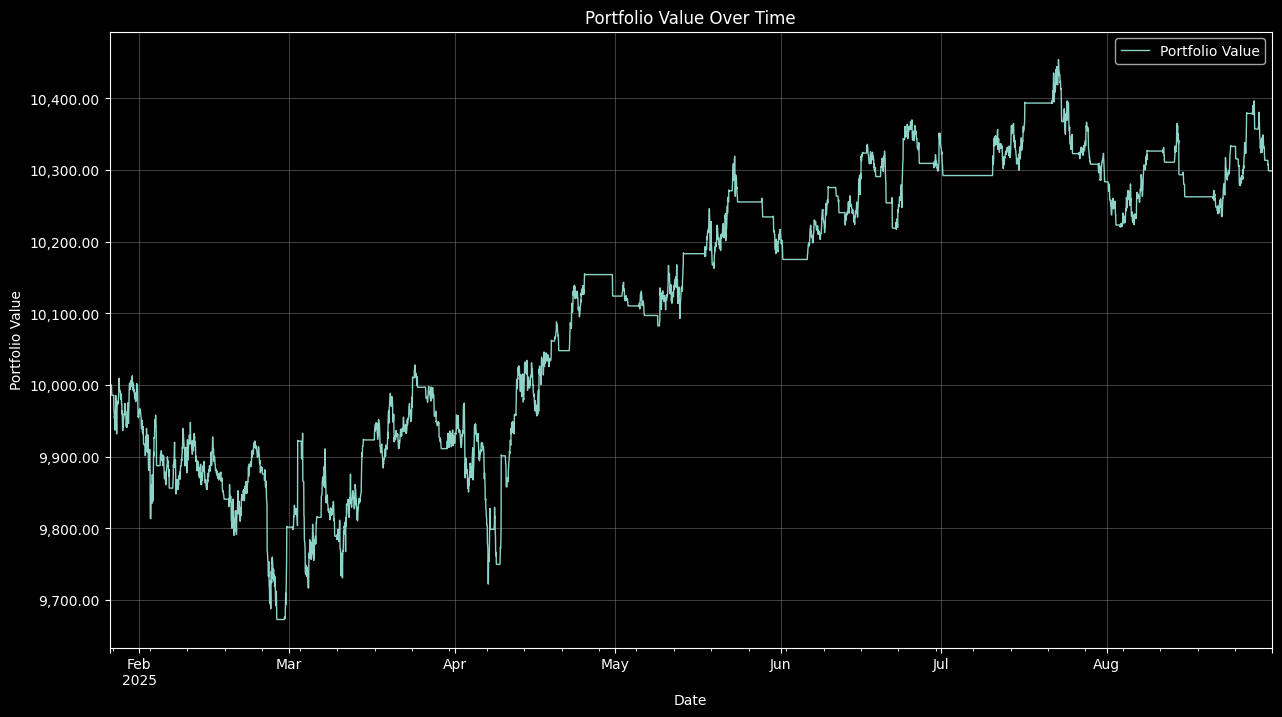

In [43]:
# Creating a Dataframe with portfolio values and predictions

portfolio_df = pd.DataFrame({'Date': portfolio_dates, 'portfolio_value': portfolio_values})
portfolio_df.set_index('Date', inplace=True)

%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
portfolio_df['portfolio_value'].plot(label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))
plt.legend()
plt.show()

## Log profobility

log_return = log(close t+1 / close t) - логорифм от часовой доходности 4:30